# Dataset exploration

In [1]:
# Importing libraries 

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import json 
import re
from nltk import word_tokenize


# Lets read the data

clickbait_data = []
with open('./clickbait_data', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        row = {}
        line = line.strip('\n')
        if line and (len(word_tokenize(line)) > 2):        #Ignore rows where there are less than 2 words eg: 'Request Timeout'
            row['title'] = line
            row['label'] = 'clickbait'
            clickbait_data.append(row)
print(len(clickbait_data))
with open('./non_clickbait_data', 'r', encoding = 'utf-8') as f:
    lines = f.readlines()
    for line in lines:
        row = {}
        line = line.strip('\n')
        if line and (len(word_tokenize(line)) > 2):
            row['title'] = line
            row['label'] = 'not-clickbait'
            clickbait_data.append(row)

data = pd.DataFrame(clickbait_data)
data

15986


,title,label
0,Should I Get Bings,clickbait
1,Which TV Female Friend Group Do You Belong In,clickbait
2,"The New ""Star Wars: The Force Awakens"" Trailer...",clickbait
3,"This Vine Of New York On ""Celebrity Big Brothe...",clickbait
4,A Couple Did A Stunning Photo Shoot With Their...,clickbait
...,...,...
31981,"To Make Female Hearts Flutter in Iraq, Throw a...",not-clickbait
31982,"British Liberal Democrat Patsy Calton, 56, die...",not-clickbait
31983,Drone smartphone app to help heart attack vict...,not-clickbait
31984,"Netanyahu Urges Pope Benedict, in Israel, to D...",not-clickbait


In [2]:
#Now lets split the data

from sklearn.model_selection import train_test_split 

train, test = train_test_split(data, shuffle = True, stratify = data.label, train_size = 10000/data.shape[0], random_state = 50)
test, _ = train_test_split(test, shuffle = True, stratify = test.label, train_size = 20000/test.shape[0], random_state = 50)

train.shape, test.shape


((10000, 2), (20000, 2))

In [3]:
train.to_csv('./train.csv', index = False)
test.to_csv('./test.csv', index = False)

### Validation of data distribution

In [4]:
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold


def adversarial_validation(X, Y, n_splits = 10):
    
    # Combine both datasets
    sparse_merge = sparse.vstack((X, Y))
    
    # Label the datasets
    y = np.array([0 for _ in range(X.shape[0])] + [1 for _ in range(Y.shape[0])])
    
    # Do 10 Fold CV 
    kfold = StratifiedKFold(n_splits = n_splits, shuffle = True)

    lr_auc = np.array([])
    rf_auc = np.array([])
    for train_idx, test_idx in kfold.split(sparse_merge, y):
    
        #Run Log Reg
        x_train, y_train = sparse_merge[train_idx], y[train_idx]
        x_test, y_test = sparse_merge[test_idx], y[test_idx]
        
        log_reg = SGDClassifier(loss = 'log')
        log_reg.fit(x_train, y_train)
        y_test_prob = log_reg.predict_proba(x_test)[:,1]
        lr_auc = np.append(lr_auc, roc_auc_score(y_test, y_test_prob))
        # Run RF
        rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
        rf.fit(x_train, y_train)
        y_test_prob = rf.predict_proba(x_test)[:,1]
        rf_auc = np.append(rf_auc, roc_auc_score(y_test, y_test_prob))

    
    # Display results
    print('Logisitic Regression AUC : {:.3f}'.format(lr_auc.mean()))
    print('Random Forest AUC : {:.3f}'.format(rf_auc.mean()))    

## Explaratory Data Analysis

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle 

bow = CountVectorizer()
x_train = bow.fit_transform(train.title.values)
x_test = bow.transform(test.title.values)

x_test = shuffle(x_test)

# adversarial_validation(x_train, x_test[:10000])

In [6]:


print('Train Positive Class % : {:.1f}'.format((sum(train.label == 'clickbait')/train.shape[0])*100))
print('Test Positive Class % : {:.1f}'.format((sum(test.label == 'clickbait')/test.shape[0])*100))

print('Train Size: {}'.format(train.shape[0]))
print('Test Size: {}'.format(test.shape[0]))



Train Positive Class % : 50.0
Test Positive Class % : 50.0
Train Size: 10000
Test Size: 20000


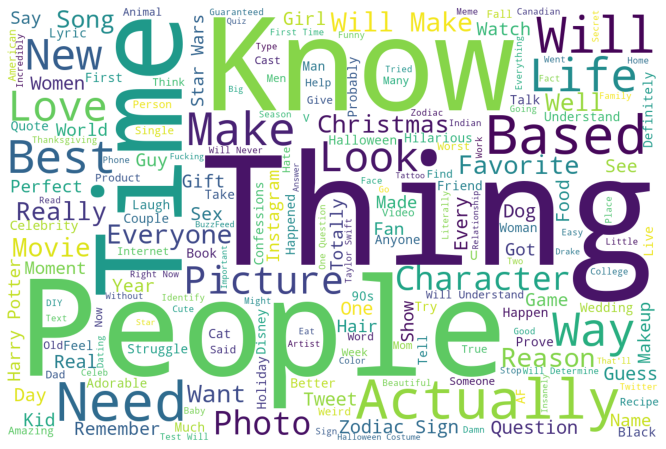

In [17]:


# %matplotlib inline
# from wordcloud import WordCloud 
# import matplotlib.pyplot as plt


# wordcloud = WordCloud(width = 1200, height = 800, 
#                 background_color ='white', 
#                 min_font_size = 10).generate(' '.join(train[train.label == 'clickbait'].title.values)) 

# plt.figure(figsize = (12, 8)) 
# plt.imshow(wordcloud) 
# plt.axis("off")
# #plt.tight_layout(pad = 0) 
  
# plt.show() 



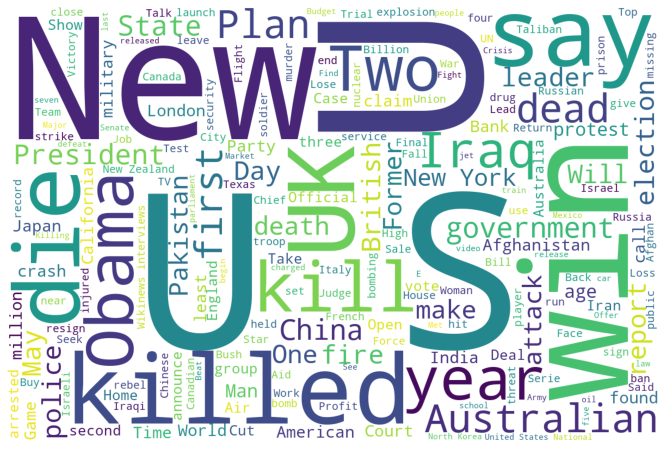

In [19]:
# %matplotlib inline
# from wordcloud import WordCloud 
# import matplotlib.pyplot as plt


# wordcloud = WordCloud(width = 1200, height = 800, 
#                 background_color ='white', 
#                 min_font_size = 10).generate(' '.join(train[train.label != 'clickbait'].title.values)) 

# plt.figure(figsize = (12, 8)) 
# plt.imshow(wordcloud) 
# plt.axis("off")
# plt.show() 



### What is the effect of number of words ? 


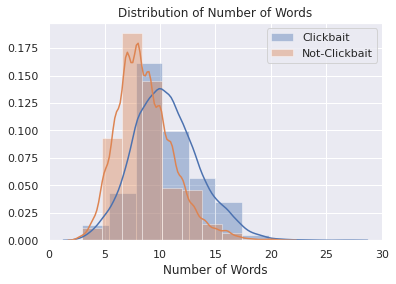

In [23]:
# %matplotlib inline
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set()
# clickbait_length = [len(word_tokenize(title)) for title in train[train.label.values == 'clickbait'].title.values]
# not_clickbait_length = [len(word_tokenize(title)) for title in train[train.label.values != 'clickbait'].title.values]

# sns.distplot(clickbait_length, bins = 10, label = 'Clickbait')
# sns.distplot(not_clickbait_length, bins = 10, label = 'Not-Clickbait')
# plt.legend()
# plt.title('Distribution of Number of Words')
# plt.xlabel('Number of Words')
# plt.show()



### Mean word length distribution

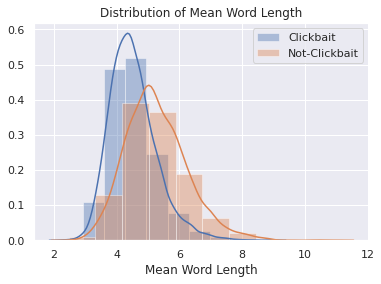

In [24]:
# def mean_word_length(x):
#     word_lengths = np.array([])
#     for word in word_tokenize(x):
#         word_lengths = np.append(word_lengths, len(word))
#     return word_lengths.mean()


# clickbait_length = train[train.label.values == 'clickbait'].title.apply(mean_word_length)
# not_clickbait_length = train[train.label.values != 'clickbait'].title.apply(mean_word_length)


# sns.distplot(clickbait_length, bins = 10, label = 'Clickbait')
# sns.distplot(not_clickbait_length, bins = 10, label = 'Not-Clickbait')
# plt.title('Distribution of Mean Word Length')
# plt.xlabel('Mean Word Length')
# plt.legend()

### Check the ratio of stop-words

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
    
def stop_words_ratio(x):
    num_total_words = 0
    num_stop_words = 0
    for word in word_tokenize(x):
        if word in stop_words:
            num_stop_words += 1
        num_total_words += 1 
    return num_stop_words/num_total_words


clickbait = train[train.label.values == 'clickbait'].title.apply(stop_words_ratio)
not_clickbait = train[train.label.values != 'clickbait'].title.apply(stop_words_ratio)


sns.distplot(clickbait, norm_hist = True, label = 'Clickbait')
sns.distplot(not_clickbait,  label = 'Not-Clickbait')

print('Clickbait Mean: {:.3f}'.format(clickbait.values.mean()))
print('Not clickbait Mean: {:.3f}'.format(not_clickbait.values.mean()))
plt.title('Distribution of Stop-word Ratio')
plt.xlabel('Stop Word Ratio')
plt.legend()

Clickbait Mean: 0.000
Not clickbait Mean: 0.159


/home/yhetman/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


## Word embeddings

In [8]:
from utility_funcitons import *
import numpy as np
y_train = np.where(train.label.values == 'clickbait', 1, 0)
y_test = np.where(test.label.values == 'clickbait', 1, 0)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
bow = CountVectorizer()
x_train = bow.fit_transform(train.title.values)
x_test = bow.transform(test.title.values)
run_log_reg(x_train, x_test, y_train, y_test)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train.title.values)
x_test = tfidf.transform(test.title.values)
run_log_reg(x_train, x_test, y_train, y_test)

F1: 0.966 | Pr: 0.962 | Re: 0.970 | AUC: 0.994 | Accuracy: 0.965 

F1: 0.962 | Pr: 0.959 | Re: 0.965 | AUC: 0.993 | Accuracy: 0.962 



SGDClassifier(loss='log', n_jobs=-1)

In [10]:
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *
from utility_funcitons import *
import numpy as np
y_train = np.where(train.label.values == 'clickbait', 1, 0)
y_test = np.where(test.label.values == 'clickbait', 1, 0)
glove = Magnitude("glove/light/glove.6B.100d")

def avg_glove(df):
    vectors = []
    for title in tqdm_notebook(df.title.values):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

x_train = avg_glove(train)
x_test = avg_glove(test)
run_log_reg(x_train, x_test, y_train, y_test)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(train.title.values)# Now lets create a dict so that for every word in the corpus we have a corresponding IDF value
idf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))# Same as Avg Glove except instead of doing a regular average, we'll use the IDF values as weights.

def tfidf_glove(df):
    vectors = []
    for title in tqdm_notebook(df.title.values):
        
        glove_vectors = glove.query(word_tokenize(title))
        
        weights = [idf_dict.get(word, 1) for word in word_tokenize(title)]
        
        vectors.append(np.average(glove_vectors, axis = 0, weights = weights))
    
    return np.array(vectors)

x_train = tfidf_glove(train)
x_test = tfidf_glove(test)

run_log_reg(x_train, x_test, y_train, y_test)

/home/yhetman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



F1: 0.976 | Pr: 0.970 | Re: 0.982 | AUC: 0.996 | Accuracy: 0.976 



SGDClassifier(loss='log', n_jobs=-1)

In [11]:
!pip install shap

     |████████████████████████████████| 371 kB 1.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=504212 sha256=ef197143dc4c1eb235717eae5e6e701dec05c53c2ca9b01528c2431eb156e09f
  Stored in directory: /home/yhetman/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [12]:

import torch
from models import InferSent
# from InferSent.models import InferSent

MODEL_PATH = './encoder/infersent1.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,'pool_type': 'max', 'dpout_model': 0.0, 'version': 1}

infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

infersent.set_w2v_path('GloVe/glove.840B.300d.txt')
infersent.build_vocab(train.title.values, tokenize= False)

x_train = infersent.encode(train.title.values, tokenize= False)
x_test = infersent.encode(test.title.values, tokenize= False)

run_log_reg(x_train, x_test, y_train, y_test, alpha = 1e-4)

Found 15191(/18408) words with w2v vectors
Vocab size : 15191


/mnt/DATA/Projects/UNIVERSITY/clickbait_text_classification/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


F1: 0.990 | Pr: 0.991 | Re: 0.990 | AUC: 0.999 | Accuracy: 0.990 



SGDClassifier(loss='log', n_jobs=-1)

## Feature Engineering

In [12]:
from feature_selection import *
import nltk
nltk.download('vader_lexicon')
train_features, test_features, feature_names = featurize(train, test, 'tfidf_glove')
run_log_reg(train_features, test_features, y_train, y_test, alpha = 5e-2)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/yhetman/nltk_data...


Starts with number....
Clickbait Phrases....
Clickbait re....
Num dots....
Text Features....
Punctuation....
Word ratios....
Sentiment Scores....
Readability Scores....



Glove.....



DONE!
F1: 0.963 | Pr: 0.956 | Re: 0.970 | AUC: 0.993 | Accuracy: 0.963 



SGDClassifier(alpha=0.05, loss='log', n_jobs=-1)

In [13]:
!pip install eli5

     |████████████████████████████████| 106 kB 1.4 MB/s eta 0:00:01


### Feature weights

In [14]:
from sklearn.linear_model import SGDClassifier
import eli5# Train a Log Reg Classifier


log_reg = SGDClassifier(loss = 'log', n_jobs = -1, alpha = 5e-2)

log_reg.fit(train_features, y_train)#Pass the model instance along with the feature names to ELI5


eli5.show_weights(log_reg, feature_names = feature_names, top = 100)

Weight?,Feature
+0.724,starts_with_number
+0.603,stop_words_ratio
+0.444,glove_14
+0.438,easy_words_ratio
+0.409,clickbait_subs_ratio
+0.314,glove_17
+0.292,glove_61
+0.265,glove_19
+0.233,glove_72
+0.229,glove_6


### Force Plot

In [15]:
import shap

log_reg = SGDClassifier(loss = 'log', n_jobs = -1, alpha = 5e-2)
log_reg.fit(train_features, y_train)

explainer = shap.LinearExplainer(log_reg, train_features,
                                 feature_dependence = 'independent')
shap_values = explainer.shap_values(test_features)


shap.initjs()
ind = 0
shap.force_plot(explainer.expected_value, shap_values[ind,:],
                test_features.toarray()[ind,:],
               feature_names = feature_names)

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


In [27]:
!pip install MulticoreTSNE

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-linux_x86_64.whl size=67193 sha256=0ad965dfc4970f8bd20329cd8052c2d218145b5fa7ced44319042e073e76fdda
  Stored in directory: /home/yhetman/.cache/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE


In [17]:
print('Title: {}'.format(test.title.values[0]))
print('Label: {}'.format(test.label.values[0]))
print('Prediction: {}'.format(log_reg.predict(test_features.tocsr()[0,:])[0]))

Title: Iran says it's ready for standoff over nuclear activities
Label: not-clickbait
Prediction: 0


In [18]:
print('Title: {}'.format(test.title.values[400]))
print('Label: {}'.format(test.label.values[400]))
print('Prediction: {}'.format(log_reg.predict(test_features.tocsr()[400,:])[0]))

Title: Can We Guess How Many People You Kissed In 2015
Label: clickbait
Prediction: 1


In [19]:
y_train = np.where(train.label.values == 'clickbait', 1, 0)
y_test = np.where(test.label.values == 'clickbait', 1, 0)

In [20]:
run_log_reg(train_features, test_features, y_train, y_test, alpha = 5e-2)

F1: 0.963 | Pr: 0.956 | Re: 0.970 | AUC: 0.993 | Accuracy: 0.963 



SGDClassifier(alpha=0.05, loss='log', n_jobs=-1)

## Exploring models

In [ ]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer
from scipy import sparse


# Create a new skelarn 'scorer' that uses our print_model_metrics function
def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)[0]
    return f1
    
score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)



# Since we want to use a predefined Test/Val set, we'll use PredefinedSplit and pass it as the CV parameter
# We need to merge both the datasets and label 0 for test and -1 for the train set

X = sparse.vstack((train_features, test_features))
test_fold = [-1 for _ in range(train_features.shape[0])] + [0 for _ in range(test_features.shape[0])]
y = np.concatenate([y_train, y_test])
ps = PredefinedSplit(test_fold)

def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = ps, n_jobs = -1, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)

In [29]:
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

bow = CountVectorizer()

x_train = bow.fit_transform(train.title.values)

tsne = TSNE(n_components = 2, n_jobs= -1, verbose = 10, perplexity = 40)
tsne_data = tsne.fit_transform(x_train.todense())

tsne_data = pd.DataFrame(tsne_data, columns = ['X', 'Y'])
tsne_data['label'] = train.label.values

sns.scatterplot(x = 'X', y = 'Y', hue = 'label', data = tsne_data)
plt.title('TSNE on BoW Title Encodings')
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 432x288 with 1 Axes>

In [30]:
from sklearn.decomposition import PCA


bow = CountVectorizer()

x_train = bow.fit_transform(train.title.values)

pca = PCA(n_components = 2)
pca_data = pca.fit_transform(x_train.todense())


pca_data = pd.DataFrame(pca_data, columns = ['X', 'Y'])
pca_data['label'] = train.label.values

sns.scatterplot(x = 'X', y = 'Y', hue = 'label', data = pca_data)
plt.title('PCA on BoW Title Encodings')
plt.show()

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 432x288 with 1 Axes>